<img src="../qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Qiskit Finance: Pricing Asian Barrier Spreads*_ 

Qiskit Finance is part of <a href="https://qiskit.org/aqua">Qiskit Aqua</a>.<br>
The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ

### Introduction
<br>
An Asian barrier spread is a combination of 3 different option types, and as such, combines multiple possible features that the Qiskit Finance option pricing framework supports::

- <a href="https://www.investopedia.com/terms/a/asianoption.asp">Asian option</a>: The payoff depends on the average price over the considered time horizon.
- <a href="https://www.investopedia.com/terms/b/barrieroption.asp">Barrier Option</a>: The payoff is zero if a certain threshold is exceeded at any time within the considered time horizon.
- <a href="https://www.investopedia.com/terms/b/bullspread.asp">(Bull) Spread</a>: The payoff follows a piecewise linear function (depending on the average price) starting at zero, increasing linear, staying constant.

Suppose strike prices $K_1 < K_2$ and time periods $t=1,2$, with corresponding spot prices $(S_1, S_2)$ following a given multivariate distribution (e.g. generated by some stochastic process), and a barrier threshold $B>0$.
The corresponding payoff function is defined as:
<br>
<br>
$$
P(S_1, S_2) =
\begin{cases}
\min\left\{\max\left\{\frac{1}{2}(S_1 + S_2) - K_1, 0\right\}, K_2 - K_1\right\}, & \text{ if } S_1, S_2 \leq B \\
0, & \text{otherwise.}
\end{cases}
$$

<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:
<br>
<br>
$$\mathbb{E}\left[ P(S_1, S_2) \right].$$
<br>
The approximation of the objective function is explained in detail in the following paper:<br>
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
%matplotlib inline
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.algorithms import AmplitudeEstimation

from arithmetic.weighted_sum_operator import WeightedSumOperator
from arithmetic.univariate_piecewise_linear_objective import UnivariatePiecewiseLinearObjective as PwlObjective
from uncertainty_problems.multivariate_objective import MultivariateObjective
from arithmetic.fixed_value_comparator import FixedValueComparator as Comparator
from random_distributions.multivariate_log_normal_distribution import MultivariateLogNormalDistribution

c:\workspaces\sandbox-git-quantum-apps\qiskit-terra-wor\qiskit\tools\qcvv\__init__.py:13: DeprecationWarning: The qiskit.tools.qcvv package is deprecated. Please use qiskit-ignis available on PIP for similar functionality and more.
  'functionality and more.', DeprecationWarning)


In [2]:
backend = BasicAer.get_backend('statevector_simulator')

### Uncertainty Model

We construct a circuit factory to load a multivariate log-normal random distribution into a quantum state on $n$ qubits.
For every dimension $j = 1,\ldots,d$, the distribution is truncated to a given interval $[low_j, high_j]$ and discretized using $2^{n_j}$ grid points, where $n_j$ denotes the number of qubits used to represent dimension $j$, i.e., $n_1+\ldots+n_d = n$.
The unitary operator corresponding to the circuit factory implements the following: 
$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i_1,\ldots,i_d} \sqrt{p_{i_1\ldots i_d}}\big|i_1\rangle_{n_1}\ldots\big|i_d\rangle_{n_d},$$
where $p_{i_1\ldots i_d}$ denote the probabilities corresponding to the truncated and discretized distribution and where $i_j$ is mapped to the right interval using the affine map:
$$ \{0, \ldots, 2^{n_j}-1\} \ni i_j \mapsto \frac{high_j - low_j}{2^{n_j} - 1} * i_j + low_j \in [low_j, high_j].$$

For simplicity, we assume both stock prices are independent and indentically distributed.
This assumption just simplifies the parametrization below and can be easily relaxed to more complex and also correlated multivariate distributions.
The only important assumption for the current implementation is that the discretization grid of the different dimensions has the same step size.

In [14]:
# number of qubits per dimension to represent the uncertainty 
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits=[num_uncertainty_qubits]*dimension
low=low*np.ones(dimension)
high=high*np.ones(dimension)
mu=mu*np.ones(dimension)
cov=sigma**2*np.eye(dimension)

# construct circuit factory
u = MultivariateLogNormalDistribution(num_qubits=num_qubits, low=low, high=high, mu=mu, cov=cov)

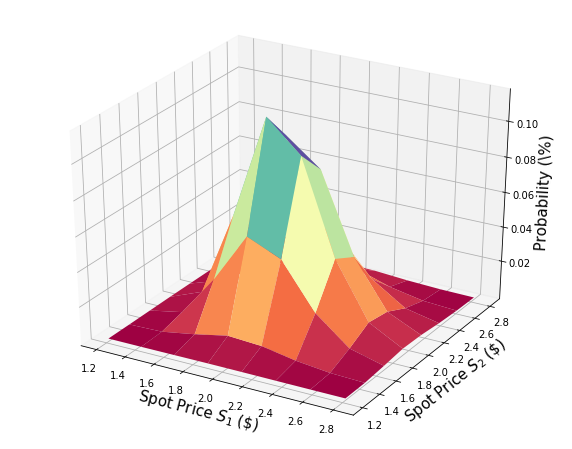

In [16]:
# plot PDF of uncertainty model
x = [ v[0] for v in u.values ]
y = [ v[1] for v in u.values ]
z = u.probabilities
#z = map(float, z)
#z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits])*1j
grid_x, grid_y = np.mgrid[min(x):max(x):resolution[0], min(y):max(y):resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel('Spot Price $S_1$ (\$)', size=15)
ax.set_ylabel('Spot Price $S_2$ (\$)', size=15)
ax.set_zlabel('Probability (\%)', size=15)
plt.show()

### Payoff Function

For simplicity, we consider the sum of the spot prices instead of their average.
The result can be transformed to the average by just dividing it by 2.

The payoff function equals zero as long as the sum of the spot prices $(S_1 + S_2)$ is less than the strike price $K_1$ and then increases linearly until the sum of the spot prices reaches $K_2$.
Then payoff stays constant to $K_2 - K_1$ unless any of the two spot prices exceeds the barrier threshold $B$, then the payoff goes immediately down to zero.
The implementation first uses a weighted sum operator to compute the sum of the spot prices into an ancilla register, and then uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $(S_1 + S_2) \geq K_1$ and another comparator/ancilla to capture the case that $(S_1 + S_2) \geq K_2$.
These ancillas are used to control the linear part of the payoff function.

In addition, we add another ancilla variable for each time step and use additional comparators to check whether $S_1$, respectively $S_2$, exceed the barrier threshold $B$. The payoff function is only applied if $S_1, S_2 \leq B$.

The linear part itself is approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation scaling factor $c_{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

Since the weighted sum operator (in its current implementation) can only sum up integers, we need to map from the original ranges to the representable range to estimate the result, and reverse this mapping before interpreting the result. The mapping essentially corresponds to the affine mapping described in the context of the uncertainty model above.

In [5]:
# determine number of qubits required to represent total loss
weights = []
for n in num_qubits:
    for i in range(n):
        weights += [2**i]
n_s = WeightedSumOperator.get_required_sum_qubits(weights)

# create circuit factory
agg = WeightedSumOperator(sum(num_qubits), weights)

In [6]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 3
strike_price_2 = 4

# set the barrier threshold
barrier = 2.5

# map strike prices and barrier threshold from [low, high] to {0, ..., 2^n-1}
max_value = 2**n_s - 1
low_ = low[0]
high_ = high[0]

mapped_strike_price_1 = (strike_price_1 - dimension*low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
mapped_strike_price_2 = (strike_price_2 - dimension*low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
mapped_barrier = (barrier - low) / (high - low) * (2**num_uncertainty_qubits - 1)

In [7]:
# condition and condition result
conditions = []
barrier_thresholds = [2]*dimension
for i in range(dimension):
    # target dimension of random distribution and corresponding condition (which is required to be True)
    conditions += [(i, Comparator(num_qubits[i], mapped_barrier[i] + 1, geq=False))]
    break  # TODO

In [8]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price_1, mapped_strike_price_2]
slopes = [0, 1, 0]
offsets = [0, 0, mapped_strike_price_2 - mapped_strike_price_1]
f_min = 0
f_max = mapped_strike_price_2 - mapped_strike_price_1
bull_spread_objective = PwlObjective(
    n_s,
    0,
    max_value,
    breakpoints,
    slopes,
    offsets,
    f_min,
    f_max,
    c_approx
)

# define overall multivariate problem
asian_barrier_spread = MultivariateObjective(u, agg, bull_spread_objective, conditions=conditions)

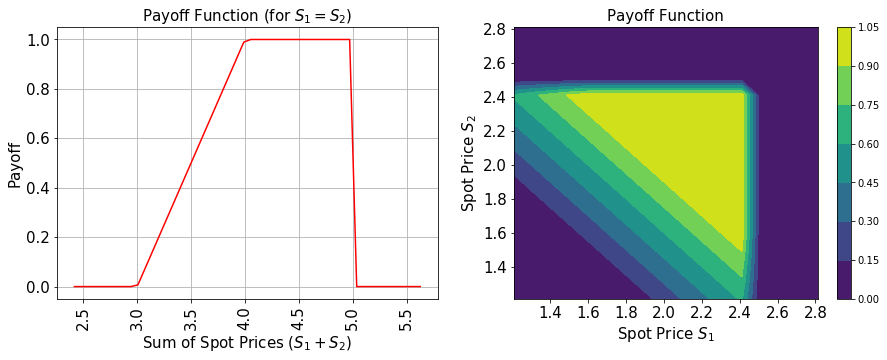

In [17]:
# plot exact payoff function
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x = np.linspace(sum(low), sum(high))
y = (x <= 5)*np.minimum(np.maximum(0, x - strike_price_1), strike_price_2 - strike_price_1)
plt.plot(x, y, 'r-')
plt.grid()
plt.title('Payoff Function (for $S_1 = S_2$)', size=15)
plt.xlabel('Sum of Spot Prices ($S_1 + S_2)$', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)

# plot contour of payoff function with respect to both time steps, including barrier
plt.subplot(1,2,2)
z = np.zeros((17, 17))
x = np.linspace(low[0], high[0], 17)
y = np.linspace(low[1], high[1], 17)
for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        z[i, j] = np.minimum(np.maximum(0, x_ + y_ - strike_price_1), strike_price_2 - strike_price_1)
        if x_ > barrier or y_ > barrier:
            z[i, j] = 0
            
plt.title('Payoff Function', size =15)
plt.contourf(x, y, z)
plt.colorbar()
# plt.plot(x, x, 'r')
plt.xlabel('Spot Price $S_1$', size=15)
plt.ylabel('Spot Price $S_2$', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [10]:
# evaluate exact expected value
sum_values = np.sum(u.values, axis=1)
payoff = np.minimum(np.maximum(sum_values - strike_price_1, 0), strike_price_2 - strike_price_1)
leq_barrier = [ np.max(v) <= barrier for v in u.values ]
exact_value = np.dot(u.probabilities[leq_barrier], payoff[leq_barrier])
print('exact expected value:\t%.4f' % exact_value)

exact expected value:	0.8023


### Evaluate Expected Payoff

We first verify the quantum circuit by simulating it and analyzing the resulting probability to measure the $|1\rangle$ state in the objective qubit

In [11]:
num_req_qubits = asian_barrier_spread.num_target_qubits
num_req_ancillas = asian_barrier_spread.required_ancillas()

q = QuantumRegister(num_req_qubits, name='q')
q_a = QuantumRegister(num_req_ancillas, name='q_a')
qc = QuantumCircuit(q, q_a)

asian_barrier_spread.build(qc, q, q_a)
print('state qubits: ', num_req_qubits)
print('circuit width:', qc.width())
print('circuit depth:', qc.depth())

state qubits:  5
circuit width: 19
circuit depth: 7760


In [13]:
type(qc.width())

int

In [12]:
job = execute(qc, backend=backend)

ModelValidationError: {'n_qubits': ["Value '19' is not the expected type <class 'int'>"]}

In [ ]:
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % asian_barrier_spread.num_target_qubits).format(i)[-asian_barrier_spread.num_target_qubits:]
    prob = np.abs(a)**2
    if prob > 1e-4 and b[0] == '1':
        value += prob

# map value to original range
mapped_value = asian_barrier_spread.value_to_estimation(value) / (2**num_uncertainty_qubits - 1) * (high_ - low_)
print('Exact Operator Value:  %.4f' % value)
print('Mapped Operator value: %.4f' % mapped_value)
print('Exact Expected Payoff: %.4f' % exact_value) 

Next we use amplitude estimation to estimate the expected payoff.

In [ ]:
# set number of evaluation qubits (=log(samples))
m = 6

# construct amplitude estimation 
ae = AmplitudeEstimation(m, asian_barrier_spread)

In [ ]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [21]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % (result['estimation']  / (2**num_uncertainty_qubits - 1) * (high_ - low_)))
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	0.8407
Estimated value:	0.8696
Probability:    	0.7163


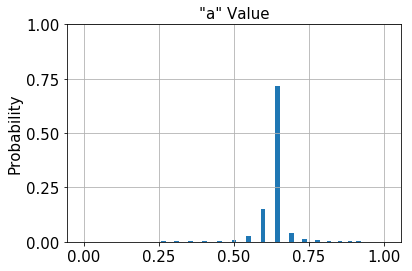

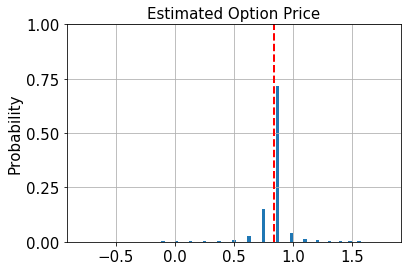

In [22]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
mapped_values = np.array(result['mapped_values']) / (2**num_uncertainty_qubits - 1) * (high_ - low_)
plt.bar(mapped_values, result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()